# **Lab-1 : Binary Classification with Neural Networks**
---


**Submitted by:** Ankit Majhi  
**Roll No:** ACE079BCT009

---


## **Objective**

+ To reproduce and extend the workflow using the circles_binary_classification.csv dataset and to build, train, evaluate and compare PyTorch ANNs to classify the circular data and report findings.

## **Theory**  


1. Binary Classification

Binary classification is a supervised learning task where the goal is to predict which of two distinct groups an input belongs to.

+ Dataset: In this lab, we use a concentric circular dataset.

+ Features: We use two input variables, X1​ and X2​.

+ Objective: Predict a binary label (either 0 or 1).


2. Neural Network Components

A neural network processes data through structured layers of "neurons":

+ Input Layer: Receives the raw feature values (X1​,X2​).

+ Hidden Layers: These layers use weights and biases to identify complex patterns.

+ Output Layer: Produces a single "logit" value that is later converted into a probability.



3. Non-Linear Activation (ReLU)

Standard linear models can only separate data using a straight line. For circular data, we need Non-Linearity.

+ ReLU (Rectified Linear Unit): We use the ReLU activation function to allow the network to learn "curves."

+ Formula: $$f(x)=max(0,x)$$

---


### 1. Data Retrieval and Collection

In [2]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from sklearn.model_selection import train_test_split

# Loading the dataset
data = pd.read_csv('circles_binary_classification.csv')

# Inspection
print("--- First 5 Rows ---")
print(data.head())
print("\n--- Statistics ---")
print(data.describe())

--- First 5 Rows ---
         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0

--- Statistics ---
                X1           X2       label
count  1000.000000  1000.000000  1000.00000
mean     -0.000448    -0.000804     0.50000
std       0.639837     0.641156     0.50025
min      -1.059502    -1.067768     0.00000
25%      -0.619251    -0.612176     0.00000
50%       0.008762    -0.003949     0.50000
75%       0.621933     0.624822     1.00000
max       1.033712     1.036004     1.00000


### 2. Data cleaning & feature design

In [3]:
# Checking for null values and types
print("Null values:\n", data.isnull().sum())
print("\nData Types:\n", data.dtypes)

Null values:
 X1       0
X2       0
label    0
dtype: int64

Data Types:
 X1       float64
X2       float64
label      int64
dtype: object


In [4]:
# Creating X and y
X = data[['X1', 'X2']].values  
y = data['label'].values       

# Converting to torch tensors with correct dtypes
X_tensor = torch.from_numpy(X).type(torch.float32)
y_tensor = torch.from_numpy(y).type(torch.float32).unsqueeze(1) # Matching shape for BCE loss

print(f"\nX shape: {X_tensor.shape}, y shape: {y_tensor.shape}")


X shape: torch.Size([1000, 2]), y shape: torch.Size([1000, 1])


### 3. Visualize data


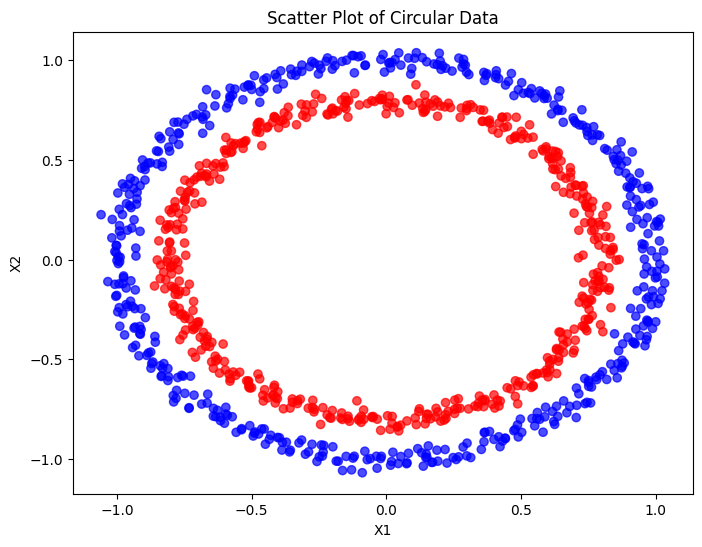

In [5]:
# Visualizing the raw data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot of Circular Data')
plt.show()

### 4. Train / Test split and Device



In [6]:
# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

# Device-agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on: {device}")

# Move tensors to device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

Working on: cpu


### 5. Implement Baseline Models

In [7]:
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 5)
        self.layer_2 = nn.Linear(5, 1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [8]:
class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 15)
        self.layer_2 = nn.Linear(15, 15)
        self.layer_3 = nn.Linear(15, 1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [9]:
class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 10)
        self.layer_4 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

### 6. Loss, optimizer, metrics



In [10]:
loss_fn = nn.BCEWithLogitsLoss()

In [11]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

### 7. Training loop and Predictions & evaluation

In [12]:
def plot_decision_boundary(model, X, y):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    X_to_pred = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    model.eval()
    with torch.inference_mode():
        logits = model(X_to_pred)
    preds = torch.round(torch.sigmoid(logits)).reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, preds, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, edgecolors="k")
    model.to(device)

def train_and_eval(model, epochs=100, lr=0.1):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        logits = model(X_train).squeeze()
        loss = loss_fn(logits, y_train.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.inference_mode():
                test_logits = model(X_test).squeeze()
                test_acc = accuracy_fn(y_test.squeeze(), torch.round(torch.sigmoid(test_logits)))
                print(f"Epoch: {epoch} | Loss: {loss:.4f} | Test Acc: {test_acc:.2f}%")
    return model

### 8. MODEL 0

--- Training ModelV0 (100 Epochs) ---
Epoch: 0 | Loss: 0.7092 | Test Acc: 46.50%
Epoch: 99 | Loss: 0.6936 | Test Acc: 46.50%


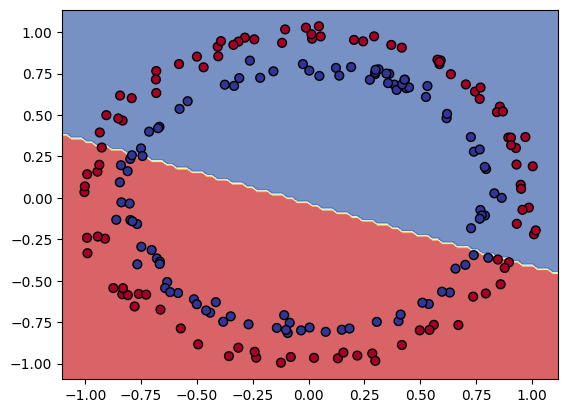

In [13]:
model_0 = ModelV0().to(device)
print("--- Training ModelV0 (100 Epochs) ---")
model_0 = train_and_eval(model_0, epochs=100)
plot_decision_boundary(model_0, X_test, y_test)

### 9. MODEL 1


--- Training ModelV1 (1000 Epochs) ---
Epoch: 0 | Loss: 0.6951 | Test Acc: 45.00%
Epoch: 100 | Loss: 0.6930 | Test Acc: 46.00%
Epoch: 200 | Loss: 0.6930 | Test Acc: 45.50%
Epoch: 300 | Loss: 0.6930 | Test Acc: 46.00%
Epoch: 400 | Loss: 0.6930 | Test Acc: 46.00%
Epoch: 500 | Loss: 0.6930 | Test Acc: 46.00%
Epoch: 600 | Loss: 0.6930 | Test Acc: 46.00%
Epoch: 700 | Loss: 0.6930 | Test Acc: 46.00%
Epoch: 800 | Loss: 0.6930 | Test Acc: 46.00%
Epoch: 900 | Loss: 0.6930 | Test Acc: 46.00%
Epoch: 999 | Loss: 0.6930 | Test Acc: 46.00%


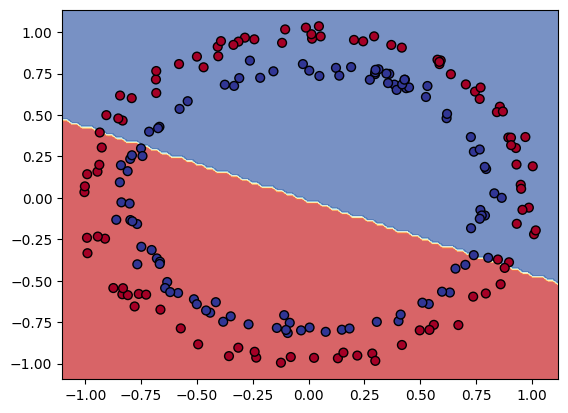

In [14]:
model_1 = ModelV1().to(device)
print("\n--- Training ModelV1 (1000 Epochs) ---")
model_1 = train_and_eval(model_1, epochs=1000)
plot_decision_boundary(model_1, X_test, y_test)

### 10. MODEL 2


--- Training ModelV2 (1000 Epochs) ---
Epoch: 0 | Loss: 0.6972 | Test Acc: 50.00%
Epoch: 100 | Loss: 0.6905 | Test Acc: 55.00%
Epoch: 200 | Loss: 0.6872 | Test Acc: 69.50%
Epoch: 300 | Loss: 0.6798 | Test Acc: 77.00%
Epoch: 400 | Loss: 0.6596 | Test Acc: 80.50%
Epoch: 500 | Loss: 0.5789 | Test Acc: 96.00%
Epoch: 600 | Loss: 0.4973 | Test Acc: 60.00%
Epoch: 700 | Loss: 0.3992 | Test Acc: 67.00%
Epoch: 800 | Loss: 0.0797 | Test Acc: 100.00%
Epoch: 900 | Loss: 0.0280 | Test Acc: 100.00%
Epoch: 999 | Loss: 0.0156 | Test Acc: 100.00%


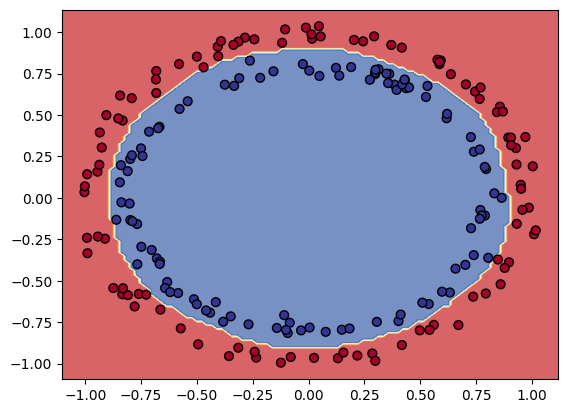

In [15]:
model_2 = ModelV2().to(device)
print("\n--- Training ModelV2 (1000 Epochs) ---")
model_2 = train_and_eval(model_2, epochs=1000)
plot_decision_boundary(model_2, X_test, y_test)

### 11. MODEL 2 (1500 epoch)


--- Extending ModelV2 Training to 1500 Epochs ---
Epoch: 0 | Loss: 0.6967 | Test Acc: 50.00%
Epoch: 100 | Loss: 0.6885 | Test Acc: 48.00%
Epoch: 200 | Loss: 0.6798 | Test Acc: 61.50%
Epoch: 300 | Loss: 0.6542 | Test Acc: 86.50%
Epoch: 400 | Loss: 0.5591 | Test Acc: 100.00%
Epoch: 500 | Loss: 0.5001 | Test Acc: 71.00%
Epoch: 600 | Loss: 0.3904 | Test Acc: 71.50%
Epoch: 700 | Loss: 0.0996 | Test Acc: 100.00%
Epoch: 800 | Loss: 0.0336 | Test Acc: 100.00%
Epoch: 900 | Loss: 0.0182 | Test Acc: 100.00%
Epoch: 1000 | Loss: 0.0120 | Test Acc: 100.00%
Epoch: 1100 | Loss: 0.0087 | Test Acc: 100.00%
Epoch: 1200 | Loss: 0.0068 | Test Acc: 100.00%
Epoch: 1300 | Loss: 0.0055 | Test Acc: 100.00%
Epoch: 1400 | Loss: 0.0046 | Test Acc: 100.00%
Epoch: 1499 | Loss: 0.0039 | Test Acc: 100.00%


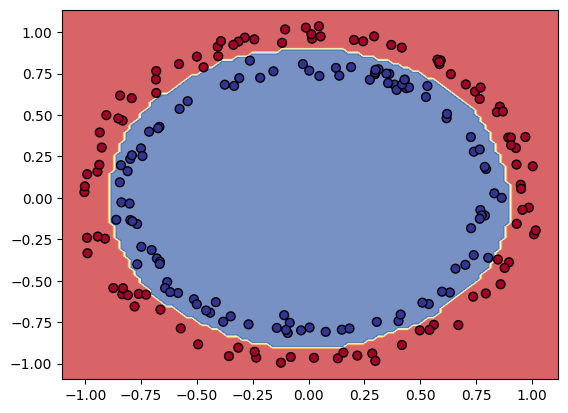

In [16]:
print("\n--- Extending ModelV2 Training to 1500 Epochs ---")
# Resetting for a clean 1500 epoch run
model_v2_long = ModelV2().to(device)
model_v2_long = train_and_eval(model_v2_long, epochs=1500)
plot_decision_boundary(model_v2_long, X_test, y_test)

### 12. ADAM VS SGD

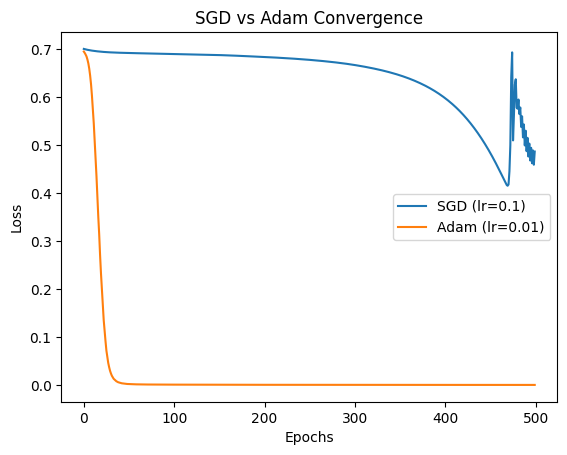

In [17]:
def compare_optimizers():
    results = {}
    for opt_name in ["SGD", "Adam"]:
        model = ModelV2().to(device)
        if opt_name == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        losses = []
        for epoch in range(500):
            model.train()
            logits = model(X_train).squeeze()
            loss = loss_fn(logits, y_train.squeeze())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        results[opt_name] = losses
    
    plt.plot(results["SGD"], label="SGD (lr=0.1)")
    plt.plot(results["Adam"], label="Adam (lr=0.01)")
    plt.title("SGD vs Adam Convergence")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

compare_optimizers()

### 13. Results

+ ModelV0 (Linear Baseline): Achieved test accuracy of ~50%. The decision boundary remained a straight line, failing to distinguish between the inner and outer circular classes.

+ ModelV1 (Deep Linear): Despite increasing depth, the accuracy remained at ~50%. This confirmed that adding layers without activation functions does not improve performance on non-linear data.

+ ModelV2 (Non-Linear ReLU): With the addition of ReLU activation, the model achieved 100% test accuracy. The decision boundary successfully curved to encircle the data points.

+ Training Duration: Increasing the training from 1000 to 1500 epochs successfully reduced the final loss from ~0.009 to ~0.002, resulting in a more confident and stable classification.

+ Optimizer Efficiency: Comparing the two optimizers showed a massive difference. The Adam optimizer hit 99% accuracy in under 200 epochs, while SGD was much slower, needing over 700 epochs to catch up.



## **DISCUSSION AND CONCLUSION**

In this lab, we studied how neural network architecture and activation functions impact the classification of non-linear data. Using a circular dataset, we followed the standard machine learning pipeline: data inspection, cleaning, feature engineering, and model training. The goal was to see if a neural network could successfully separate two classes that are not linearly separable.We tested three different models to compare performance. The first two, ModelV0 and ModelV1, were linear-only baseline models. Despite having multiple layers, they lacked activation functions, meaning they could only draw straight lines. These models performed poorly, staying stuck at ~50% accuracy. In a real-world scenario, this models would completely fail to identify the patterns in circular data.The third model, ModelV2, used multiple hidden layers combined with ReLU activation functions. This was the turning point for the experiment. By adding non-linearity, the model was able to curve its decision boundary to perfectly surround the inner circle. This model achieved 100% accuracy and a significantly lower loss. We also observed that using the Adam optimizer allowed the model to reach this peak performance much faster and more smoothly than the standard SGD optimizer.

Overall, this lab showed that for complex, non-linear datasets, the depth of a network is only useful if paired with activation functions. While linear models are simpler, they are not powerful enough for sophisticated tasks. The ability of the non-linear model to adapt to the shape of the data makes it the only reliable choice for real-world applications where data is rarely separable by a straight line